In this notebook I benchmark a few text categorization models to test whehter word embeddings like word2vec can improve text classification accuracy. The the notebook proceeds as follows:
1. downloading the datasets
2. construction of the training set
3. definitions of models
4. benchmarking models
5. plotting results

Downloading datasets and pretrained wector embeddings. Especially the embeddings can take a while to download. You might want run these in the terminal instead to see wget's progress bar. If you're on Windows (and not in cygwin) %%bash cell magic won't work and you'll have to do all this manually (or with %%cmd magic I guess). 

In [186]:
%%bash
# # download Reuters' text categorization benchmarks
# wget http://www.cs.umb.edu/~smimarog/textmining/datasets/r8-train-all-terms.txt
# wget http://www.cs.umb.edu/~smimarog/textmining/datasets/r8-test-all-terms.txt
# # concatenate train and test files, we'll make our own train-test splits
# cat r8-*-all-terms.txt > r8-all-terms.txt
# wget http://www.cs.umb.edu/~smimarog/textmining/datasets/r52-train-all-terms.txt
# wget http://www.cs.umb.edu/~smimarog/textmining/datasets/r52-test-all-terms.txt
# cat r52-*-all-terms.txt > r52-all-terms.txt

# download Reuters' text categorization benchmarks
wget http://www.cs.umb.edu/~smimarog/textmining/datasets/r8-train-no-stop.txt
wget http://www.cs.umb.edu/~smimarog/textmining/datasets/r8-test-no-stop.txt
# concatenate train and test files, we'll make our own train-test splits
cat r8-*-no-stop.txt > r8-no-stop.txt
wget http://www.cs.umb.edu/~smimarog/textmining/datasets/r52-train-no-stop.txt
wget http://www.cs.umb.edu/~smimarog/textmining/datasets/r52-test-no-stop.txt
cat r52-*-no-stop.txt > r52-no-stop.txt

--2016-05-14 21:20:04--  http://www.cs.umb.edu/~smimarog/textmining/datasets/r8-train-no-stop.txt
Resolving www.cs.umb.edu (www.cs.umb.edu)... 158.121.106.222
Connecting to www.cs.umb.edu (www.cs.umb.edu)|158.121.106.222|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2537362 (2.4M) [text/plain]
Saving to: ‘r8-train-no-stop.txt’

     0K .......... .......... .......... .......... ..........  2%  289K 8s
    50K .......... .......... .......... .......... ..........  4%  576K 6s
   100K .......... .......... .......... .......... ..........  6%  586K 5s
   150K .......... .......... .......... .......... ..........  8% 11.7M 4s
   200K .......... .......... .......... .......... .......... 10%  605K 4s
   250K .......... .......... .......... .......... .......... 12% 10.9M 3s
   300K .......... .......... .......... .......... .......... 14%  184K 4s
   350K .......... .......... .......... .......... .......... 16%  293M 4s
   400K .......... .......... .....

In [3]:
%%bash
# download GloVe word vector representations
# bunch of small embeddings - trained on 6B tokens - 822 MB download, 2GB unzipped
wget http://nlp.stanford.edu/data/glove.6B.zip
unzip glove.6B.zip

# and a single behemoth - trained on 840B tokens - 2GB compressed, 5GB unzipped
wget http://nlp.stanford.edu/data/glove.840B.300d.zip
unzip glove.840B.300d.zip

--2016-05-14 09:59:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

     0K .......... .......... .......... .......... ..........  0%  110K 2h7m
    50K .......... .......... .......... .......... ..........  0%  165K 1h45m
   100K .......... .......... .......... .......... ..........  0%  332K 84m45s
   150K .......... .......... .......... .......... ..........  0%  166K 84m41s
   200K .......... .......... .......... .......... ..........  0%  166K 84m37s
   250K .......... .......... .......... .......... ..........  0%  167K 84m32s
   300K .......... .......... .......... .......... ..........  0%  333K 78m29s
   350K .......... .......... .......... .......... ..........  0%  166K 79m14s
   400K .......... .......... ....

In [240]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import numpy as np
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

# TRAIN_SET_PATH = "r52-all-terms.txt"
TRAIN_SET_PATH = "r8-no-stop.txt"

GLOVE_6B_50D_PATH = "glove.6B.50d.txt"
GLOVE_840B_300D_PATH = "glove.840B.300d.txt"

In [245]:
X, y = [], []
with open(TRAIN_SET_PATH, "rb") as infile:
    for line in infile:
        label, text = line.split("\t")
        # texts are already tokenized, just split on space
        # in a real case we would use e.g. spaCy for tokenization
        # and maybe remove stopwords etc.
        X.append(text.split())
        y.append(label)
X, y = np.array(X), np.array(y)
print "total examples %s" % len(y)

total examples 7674


Prepare word embeddings - both the downloaded pretrained ones and train a new one from scratch

In [201]:
# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our training set
# if you wan't to play around with the vectors and have 
# enough RAM - remove the 'if' line and load everything

glove_small = {}
all_words = set(w for words in X for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = map(float, parts[1:])
        if word in all_words:
            glove_small[word] = np.array(nums)
            
glove_big = {}
with open(GLOVE_840B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = map(float, parts[1:])
        if word in all_words:
            glove_big[word] = np.array(nums)

In [202]:
# train word2vec on all the texts - both training and test set
# we're not using test labels, just texts so this is fine
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
model.index2word
w2v = {w: vec for w, vec in zip(model.index2word, model.syn0)}

Time for model definitions

In [237]:
# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
# SVM - which is supposed to be more or less state of the art 
# http://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf
svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

Now the meat - classifiers using vector embeddings. We will implement an embedding vectorizer - a counterpart of CountVectorizer and TfidfVectorizer - that is given a word -> vector mapping and vectorizes texts by taking the mean of all the vectors corresponding to individual words.

In [204]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec], axis=0)
            for words in X
        ])
    
# and a tf-idf version of the same

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec ], axis=0)
                for words in X
            ])

In [217]:
# Extra Trees classifier is almost universally great, let's stack it with our embeddings
etree_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_small_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

benchmark all the things!

In [317]:
all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("glove_small", etree_glove_small), 
    ("glove_small_tfidf", etree_glove_small_tfidf),
    ("glove_big", etree_glove_big), 
    ("glove_big_tfidf", etree_glove_big),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
]
scores = sorted([(name, cross_val_score(model, X, y, cv=5).mean()) 
                 for name, model in all_models], 
                key=lambda (_, x): -x)
print tabulate(scores, floatfmt=".4f", headers=("model", 'score'))

model                score
-----------------  -------
w2v_tfidf           0.9327
w2v                 0.9223
glove_big           0.8814
glove_big_tfidf     0.8710
mult_nb             0.8606
glove_small         0.8413
glove_small_tfidf   0.8413
svc                 0.7821
svc_tfidf           0.7804
bern_nb             0.6603
bern_nb_tfidf       0.6603
mult_nb_tfidf       0.6410


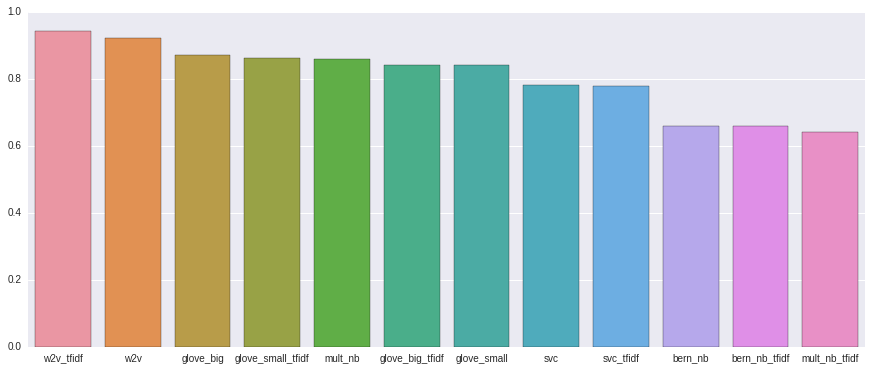

In [314]:
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])

ok, this is how it is. Let's see if the r

In [294]:
train_sizes = [10, 40, 160, 640, 3200, 6400]
table = []
for name, model in [("mult_nb", mult_nb), ("mult_nb_tfidf", mult_nb_tfidf)]:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)

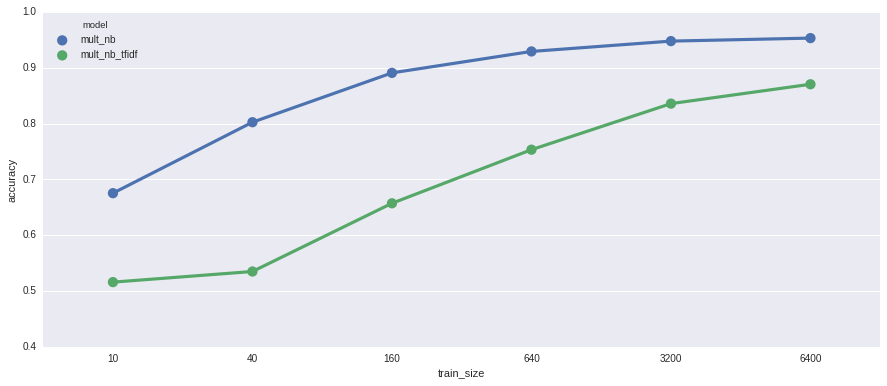

In [315]:
plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', data=df)
fig.set(ylabel="accuracy")

In [322]:
etree_glove_big.fit([['gold', 'sliver'], ['london', 'berlin'], ['cow', 'cat']], ['metals', 'capitals', 'animals'])
etree_glove_big.predict([['platinum'], 
                       ['berlin'], 
                       ['dog']])


array(['metals', 'capitals', 'animals'], 
      dtype='|S8')